In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import os
import seaborn as sns

In [10]:
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import ema_logging
from ema_workbench import MultiprocessingEvaluator

from ema_workbench.analysis import parcoords

In [11]:
ema_logging.log_to_stderr(ema_logging.INFO)

"""
    Parameters
    ----------
    problem_formulation_id : int {0, ..., 6}
                             problem formulations differ with respect to the objectives
                             0: Total cost, and casualties
                             1: Expected damages, costs, and casualties
                             2: expected damages, dike investment costs, rfr costs, evacuation cost, and casualties
                             3: costs and casualties disaggregated over dike rings, and room for the river and evacuation costs
                             4: Expected damages, dike investment cost and casualties disaggregated over dike rings and room for the river and evacuation costs
                             5: disaggregate over time and space
                             6: Same as 3 but only aggregated for Gelderland, NOTE Expected annual damage only represents Gelderland

    """
problem_formulation = 6  # Change this to the desired problem formulation ID
dike_model, planning_steps = get_model_for_problem_formulation(problem_formulation)

In [12]:
for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)


CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [13]:
from ema_workbench import ScalarOutcome, Scenario

# List of outcomes you want to optimize
objectives = ['Expected Annual Damage', 'Expected Number of Deaths']

# # Loop over all outcomes
# for outcome in dike_model.outcomes:
#     if outcome.name in objectives:
#         outcome.kind = ScalarOutcome.MINIMIZE 
#     else:
#         outcome.kind = ScalarOutcome.INFO  # neutral, will be ignored in optimization


for outcome in dike_model.outcomes:
    print(f"{outcome.name}: kind={outcome.kind}")

reference_scenario = Scenario('Reference Scenario', **dict({
    'discount rate 0': 2.5,
    'discount rate 1': 2.5,
    'discount rate 2': 2.5,
    'A.0_ID flood wave shape': 4,
    'A.1_Bmax': 175,
    'A.2_Bmax': 175,
    'A.3_Bmax': 175,
    'A.4_Bmax': 175,
    'A.5_Bmax': 175,
    'A.1_pfail': 0.5,
    'A.2_pfail': 0.5,
    'A.3_pfail': 0.5,
    'A.4_pfail': 0.5,
    'A.5_pfail': 0.5,
    'A.1_Brate': 1.5,
    'A.2_Brate': 1.5,
    'A.3_Brate': 1.5,
    'A.4_Brate': 1.5,
    'A.5_Brate': 1.5
}))



A.1 Total Costs: kind=-1
A.1_Expected Number of Deaths: kind=-1
A.2 Total Costs: kind=-1
A.2_Expected Number of Deaths: kind=-1
A.3 Total Costs: kind=-1
A.3_Expected Number of Deaths: kind=-1
Expected Evacuation Costs: kind=-1
Expected Annual Damage: kind=-1
Expected Number of Deaths: kind=-1


In [16]:
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress
# convergence_metrics = [
#     ArchiveLogger('data/test_runs', [l.name for l in dike_model.levers], 
#                   [o.name for o in dike_model.outcomes], 
#                   base_filename='pf6_run.tar.gz'),
#     EpsilonProgress()
# ]

with MultiprocessingEvaluator(dike_model) as evaluator:
    results1 = evaluator.optimize(nfe=1000, searchover='levers',  epsilons=[0.1,]*len(dike_model.outcomes), reference=reference_scenario,)

[MainProcess/INFO] pool started with 16 workers
100%|██████████████████████████████████████| 1000/1000 [00:29<00:00, 34.42it/s]
[MainProcess/INFO] optimization completed, found 67 solutions
[MainProcess/INFO] terminating pool


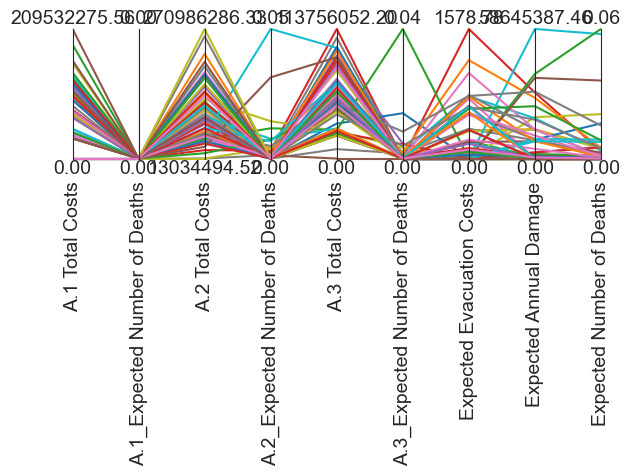

In [17]:
data = results1.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()